In [89]:
import pandas as pd
import os 
dirs = os.getcwd() 
files = os.listdir(dirs) 
files

['all_data_total_EU_secondary_income_eu_GDP_1_bankup_v2.1.csv',
 'all_data_total_EU_secondary_income_eu_GDP_1 _bu_v1.1.csv',
 'qe from start v1.2ipynb.ipynb',
 '.DS_Store',
 'all_data_total_EU_secondary_income_eu_GDP_1_bankup.csv',
 'all_data_total_EU_secondary_income_eu_GDP_1_bankup_v3.1.csv',
 'qe from start v1.0.ipynb',
 'data0_v1.xlsx',
 '.ipynb_checkpoints',
 'all_data_total_EU_secondary_income_eu_GDP_1.csv',
 'all_data_total_EU_secondary_income_eu_GDP_1 복사본.csv']

In [90]:
# Sources
# https://matheusfacure.github.io/python-causality-handbook/15-Synthetic-Control.html
# https://nbviewer.jupyter.org/github/OscarEngelbrektson/SyntheticControlMethods/blob/master/examples/user_guide.ipynb

In [91]:
import warnings
import copy
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.formula.api as smf
import os 
from typing import List
from operator import add
from toolz import reduce, partial
from scipy import stats
from scipy.optimize import fmin_slsqp
from scipy.stats import ttest_ind
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression,Ridge
from matplotlib import style
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option("display.max_columns", 6)
style.use("fivethirtyeight")

# read data file
# pandas read_csv

dirs = os.getcwd() 
files = os.listdir(dirs) 

data_c = pd.read_csv(r'/Users/jinhyun/Documents/GitHub/Python/UvA projects/Thesis/bsc/data/all_data_total_EU_GDP_CA_1.csv') 
data_c = data_c.loc[data_c.year >= 2006]
raw_data_c = copy.deepcopy(data_c)# Copy dataframe

data_g = pd.read_csv(r'/Users/jinhyun/Documents/GitHub/Python/UvA projects/Thesis/bsc/data/all_data_total_EU_export_of_Goods_eu_GDP_1.csv') 
data_g = data_g.loc[data_g.year >= 2006]
raw_data_g = copy.deepcopy(data_g)# Copy dataframe

data_s = pd.read_csv(r'/Users/jinhyun/Documents/GitHub/Python/UvA projects/Thesis/bsc/data/all_data_total_EU_export_of_Service_eu_GDP_1.csv') 
data_s = data_s.loc[data_s.year >= 2006]
raw_data_s = copy.deepcopy(data_s)# Copy dataframe

data_g_s = pd.read_csv(r'/Users/jinhyun/Documents/GitHub/Python/UvA projects/Thesis/bsc/data/all_data_total_EU_export_of_goods_service_eu_GDP_1.csv') 
data_g_s = data_g_s.loc[data_g_s.year >= 2006]
raw_data_g_s = copy.deepcopy(data_g_s)# Copy dataframe

data_primary = pd.read_csv(r'/Users/jinhyun/Documents/GitHub/Python/UvA projects/Thesis/bsc/data/all_data_total_EU_primary_income_eu_GDP_1.csv') 
data_primary = data_primary.loc[data_primary.year >= 2006]
raw_data_primary = copy.deepcopy(data_primary)# Copy dataframe

data_secondary = pd.read_csv(r'/Users/jinhyun/Documents/GitHub/Python/UvA projects/Thesis/MSc/ascm/다시 2/all_data_total_EU_secondary_income_eu_GDP_1_bankup_v3.1.csv') 
data_secondary = data_secondary.loc[data_secondary.year >= 2006]
raw_data_secondary = copy.deepcopy(data_secondary)# Copy dataframe



In [92]:
data_secondary

,country,year,Secondary income,...,3,4,5
46,Algeria,2006,2.659427,...,1.471150,33641007,108.156570
47,Algeria,2007,2.713455,...,1.551379,34166976,109.531708
48,Algeria,2008,2.775823,...,1.636169,34730604,109.230972
49,Algeria,2009,2.818996,...,1.722108,35333882,112.358971
50,Algeria,2010,2.867782,...,1.805005,35977451,115.337578
...,...,...,...,...,...,...,...
4830,Zimbabwe,2017,1.276544,...,1.459406,14236599,98.933189
4831,Zimbabwe,2018,1.323497,...,1.410382,14438812,97.750809
4832,Zimbabwe,2019,1.424249,...,1.421142,14645473,97.140213
4833,Zimbabwe,2020,1.573169,...,1.473871,14862927,97.304909


In [93]:
# Divide data by the year 2016 to check descriptive statistics

# raw_data_c.describe().loc[raw_data_c.country == 'EU'].to_excel('1ca.xlsx')
# raw_data_c.loc[raw_data_c.year <= 2016].loc[raw_data_c.country == 'EU'].describe().to_excel('1ca_before_e.xlsx')
# raw_data_c.loc[raw_data_c.year >  2016].loc[raw_data_c.country == 'EU'].describe().to_excel('1ca_after_e.xlsx')

# raw_data_g.describe().loc[raw_data_g.country == 'EU'].to_excel('1goods.xlsx')
# raw_data_g.loc[raw_data_g.year <= 2016].loc[raw_data_g.country == 'EU'].describe().to_excel('1g_before_e.xlsx')
# raw_data_g.loc[raw_data_g.year >  2016].loc[raw_data_g.country == 'EU'].describe().to_excel('1g_after_e.xlsx')

# raw_data_s.describe().loc[raw_data_s.country == 'EU'].to_excel('0service.xlsx')
# raw_data_s.loc[raw_data_s.year <= 2016].loc[raw_data_s.country == 'EU'].describe().to_excel('1s_before_e.xlsx')
# raw_data_s.loc[raw_data_s.year >  2016].loc[raw_data_s.country == 'EU'].describe().to_excel('1s_after_e.xlsx')

# raw_data_g_s.describe().loc[raw_data_g_s.country == 'EU'].to_excel('0gs.xlsx')
# raw_data_g_s.loc[raw_data_g_s.year <= 2016].loc[raw_data_g_s.country == 'EU'].describe().to_excel('1gs_before_e.xlsx')
# raw_data_g_s.loc[raw_data_g_s.year >  2016].loc[raw_data_g_s.country == 'EU'].describe().to_excel('1gs_after_e.xlsx')


# raw_data_primary.describe().loc[raw_data_primary.country == 'EU'].to_excel('0primary.xlsx')
# raw_data_primary.loc[raw_data_primary.year <= 2016].loc[raw_data_primary.country == 'EU'].describe().to_excel('1p_before_e.xlsx')
# raw_data_primary.loc[raw_data_primary.year >  2016].loc[raw_data_primary.country == 'EU'].describe().to_excel('1p_after_e.xlsx')

# raw_data_secondary.describe().loc[raw_data_primary.country == 'EU'].to_excel('0secondary.xlsx')
# raw_data_secondary.loc[raw_data_secondary.year <= 2016].loc[raw_data_primary.country == 'EU'].describe().to_excel('1se_before_e.xlsx')
# raw_data_secondary.loc[raw_data_secondary.year >  2016].loc[raw_data_primary.country == 'EU'].describe().to_excel('1se_after_e.xlsx')

In [94]:
display(data_g)

,country,year,Export of goods,...,education,unemployment rate,GDP growth rate
0,Brazil,2006,913,...,9.912729,8.640000,11.042234
1,Brazil,2007,1114,...,9.912729,8.330000,12.918339
2,Brazil,2008,1677,...,9.912729,7.340000,14.265880
3,Brazil,2009,1759,...,9.912729,8.520000,7.168936
4,Brazil,2010,2169,...,8.328785,7.740000,16.647691
...,...,...,...,...,...,...,...
130,EU,2016,142309,...,1.130620,9.150000,2.100000
131,EU,2017,163629,...,1.130620,8.158334,2.800000
132,EU,2018,172968,...,1.130620,7.283333,2.100000
133,EU,2019,170578,...,1.130620,6.716667,1.600000


In [95]:
display(data_s)

,country,year,Export of service,...,education,unemployment rate,GDP growth rate
0,Brazil,2006,582,...,9.912729,8.640000,11.042234
1,Brazil,2007,548,...,9.912729,8.330000,12.918339
2,Brazil,2008,876,...,9.912729,7.340000,14.265880
3,Brazil,2009,811,...,9.912729,8.520000,7.168936
4,Brazil,2010,1109,...,8.328785,7.740000,16.647691
...,...,...,...,...,...,...,...
130,EU,2016,103311,...,1.130620,9.150000,2.100000
131,EU,2017,114367,...,1.130620,8.158334,2.800000
132,EU,2018,125287,...,1.130620,7.283333,2.100000
133,EU,2019,120622,...,1.130620,6.716667,1.600000


In [96]:
display(data_g_s)

,country,year,Total exports of goods and services,...,education,unemployment rate,GDP growth rate
0,Brazil,2006,1495,...,9.912729,8.640000,11.042234
1,Brazil,2007,1662,...,9.912729,8.330000,12.918339
2,Brazil,2008,2553,...,9.912729,7.340000,14.265880
3,Brazil,2009,2570,...,9.912729,8.520000,7.168936
4,Brazil,2010,3278,...,8.328785,7.740000,16.647691
...,...,...,...,...,...,...,...
130,EU,2016,245620,...,1.130620,9.150000,2.100000
131,EU,2017,277996,...,1.130620,8.158334,2.800000
132,EU,2018,298255,...,1.130620,7.283333,2.100000
133,EU,2019,291200,...,1.130620,6.716667,1.600000


In [97]:
display(data_primary)

,country,year,Primary income,...,education,unemployment rate,GDP growth rate
0,Brazil,2006,999,...,9.912729,8.640000,11.042234
1,Brazil,2007,1425,...,9.912729,8.330000,12.918339
2,Brazil,2008,1150,...,9.912729,7.340000,14.265880
3,Brazil,2009,1409,...,9.912729,8.520000,7.168936
4,Brazil,2010,2162,...,8.328785,7.740000,16.647691
...,...,...,...,...,...,...,...
130,EU,2016,55619,...,1.130620,9.150000,2.100000
131,EU,2017,68304,...,1.130620,8.158334,2.800000
132,EU,2018,77832,...,1.130620,7.283333,2.100000
133,EU,2019,77993,...,1.130620,6.716667,1.600000


In [98]:
display(data_secondary)

,country,year,Secondary income,...,3,4,5
46,Algeria,2006,2.659427,...,1.471150,33641007,108.156570
47,Algeria,2007,2.713455,...,1.551379,34166976,109.531708
48,Algeria,2008,2.775823,...,1.636169,34730604,109.230972
49,Algeria,2009,2.818996,...,1.722108,35333882,112.358971
50,Algeria,2010,2.867782,...,1.805005,35977451,115.337578
...,...,...,...,...,...,...,...
4830,Zimbabwe,2017,1.276544,...,1.459406,14236599,98.933189
4831,Zimbabwe,2018,1.323497,...,1.410382,14438812,97.750809
4832,Zimbabwe,2019,1.424249,...,1.421142,14645473,97.140213
4833,Zimbabwe,2020,1.573169,...,1.473871,14862927,97.304909


In [99]:
# Standardize independent variables
# mean 0 / variance 1

data_c[['inflation','education','unemployment rate','GDP growth rate']] = StandardScaler().fit_transform(data_c[['inflation','education','unemployment rate','GDP growth rate']])

data_g[['inflation','education','unemployment rate','GDP growth rate']] = StandardScaler().fit_transform(data_g [['inflation','education','unemployment rate','GDP growth rate']])

data_g[['inflation','education','unemployment rate','GDP growth rate']] = StandardScaler().fit_transform(data_g_s[['inflation','education','unemployment rate','GDP growth rate']])

data_primary[['inflation','education','unemployment rate','GDP growth rate']] = StandardScaler().fit_transform(data_primary[['inflation','education','unemployment rate','GDP growth rate']])

data_secondary[['inflation','education','unemployment rate','GDP growth rate']] = StandardScaler().fit_transform(data_secondary[['inflation','education','unemployment rate','GDP growth rate']])



# 1. Raw data

In [100]:
def visulaize_origianl(country,interested_variable, data0):
  """
  Make graph with interested variable and country
  This function is to visulize the raw data 
  """

  # Make data0set that is only about entered country 
  str_expr = f"country == '{country}' " 
  data0_new = data0.query(str_expr) 

  plt.figure(figsize=(10,5)) 
  plt.plot(data0['year'],data0[interested_variable],marker="o",alpha=.6, label = f'{interested_variable} with Non {country}',color='dimgray')
  plt.plot(data0_new['year'],data0_new[interested_variable],label = f'{interested_variable} with {country}',color='black')   
  plt.vlines(x=2016,   ymin=-200000, ymax=200000, linestyle=":", lw=2, label="Brexit")
  plt.gray()
  plt.legend();  
  plt.show()


# 2. Synthetic Control Method

In [101]:
def X_y(country, main_variable, data0):
  """
   Get X and y
  """

  features = ['inflation',"education",'unemployment rate','GDP growth rate']

  #Make new dummy variable 'Brexit'
  data0['Brexit'] = [1 if t else 0 for t in list(data0['year'] > 2016.0)]

  # make data only about selected country
  str_expr = f"country == '{country}' "   
  data0_country = data0.query(str_expr) 

  # .T  flip the table to have one column per state
  inverted = data0.query("Brexit == 0").pivot(index='country', columns="year")[features].T
  
  # Replace the missing value
  inverted = inverted.fillna(method='pad')
  
  # Set X and y
  y = inverted[country].values
  X = inverted.drop(columns= country).values

  return X,y

def loss_w(W, X, y) -> float:
    return np.sqrt(np.mean((y - X.dot(W))**2))

def get_w(X, y):
    w_start = [1/X.shape[1]]*X.shape[1]

    weights = fmin_slsqp(partial(loss_w, X=X, y=y),
                         np.array(w_start),
                         f_eqcons=lambda x: np.sum(x) - 1,
                         bounds=[(0.0, 1.0)]*len(w_start),
                         disp=False)
    return weights

def sythetic_weight(country, interested_variable, data0):   
  """
  Get the weight of synthetic control.
  """

  data_weights = get_w(X_y(country, interested_variable, data0)[0], X_y(country, interested_variable, data0)[1])
  print("Sum of weight:", data_weights.sum())

  return np.round(data_weights, 4)

def synthetic_control(country, main_variable, data0):
  """
  This function is to generate the value of Synthetic Control

  Country : The country you want to see
  pool: list of country in data set
  main_variable: Variable you want to see. ex) CA
  data0 : data that you have
  
  """

  #Make new dummy variable 'Brexit'
  data0['Brexit'] = [1 if t else 0 for t in list(data0['year'] > 2016.0)]

  # make data only about selected country
  str_expr = f"country == '{country}' "   
  data0_country = data0.query(str_expr) 

  # .T  flip the table to have one column per state
  features = [main_variable,'unemployment rate', "education",'inflation','GDP growth rate']
  inverted = data0.query("Brexit == 0").pivot(index='country', columns="year")[features].T
  
  # Replace the missing value
  inverted = inverted.fillna(method='pad')
  
  # Set X and y
  y = inverted[country].values
  X = inverted.drop(columns= country).values
  
  # Find the synthetic controls of countries in the pool or a given dataset
  weights_synth = sythetic_weight(country, main_variable, data0)
  weights_synth.round(3)

  #select countries without country and make tables about main variable entered
  data1 = data0.query(f"country != '{country}' ").pivot(index='year', columns="country")[main_variable]

  # multiply values of main variable with weight that we have gotten
  data_synth_lr = data1.values.dot(weights_synth)

  data0_country['Synthetic'] = data_synth_lr

  return data0_country


def synthetic_control_dataframe(country, main_variable, data0):
 
  """
  This function is to make dataframe that contain the value of Synthetic Control

  Country : The country you want to see
  pool: list of country in data set
  main_variable: Variable you want to see. ex) CA
  data0 : data that you have
  """

  # Deepcopy dataframe
  data1 = copy.deepcopy(data0)

  # Make dataframe that contain values of augmented synthetic control
  data2 = synthetic_control(country, main_variable, data1)

  # Add column of difference
  data2[f'Difference'] = data2[main_variable]- data2['Synthetic']

  # Make dataframe that contain pre-treatment period only
  data_pre = data2.loc[data2.year <= 2016]

  # Make dataframe that contain post-treatment period only
  data_post = data2.loc[data2.year > 2016]

  # Calculate RMSPE for pre-treatment period only
  rmspe = rmse(data_pre[main_variable], data_pre['Synthetic'])
  print('Pre- RMSPE :', rmspe )

  # Calculate RMSPE for post-treatment period only
  rmspe = rmse(data_post[main_variable], data_post['Synthetic'])
  print('Post- RMSPE :', rmspe )

  return data2[['country','year',main_variable,'Synthetic','Difference']]

def synthetic_plot(country,main_variable, data0):
  """
  Show the plot of synthetic control
  """
  features = [main_variable]
  data_synth_1 = data0.query(f"country != '{country}' ").pivot(index='year', columns="country")[features].values.dot(sythetic_weight(country, 'CA', data0))
  
  plt.figure(figsize=(10,6))
  plt.plot(data0.query(f"country == '{country}'")["year"], data0.query(f"country == '{country}'")[features], label=f"{country}",color='dimgray')
  plt.plot(data0.query(f"country == '{country}'")["year"], data_synth_1, label="Synthetic Control",color='black')
  plt.vlines(x=2016, ymin=-200000, ymax=200000, linestyle=":", lw=2, label="Brexit")
  plt.ylabel(f"{main_variable} ")
  plt.legend();

def synthetic_plot_magnified(country,main_variable, data0):
  """
  Show the plot of synthetic control with samll values of main_variable
  """
  features = [main_variable]
  data_synth_1 = data0.query(f"country != '{country}' ").pivot(index='year', columns="country")[features].values.dot(sythetic_weight(country, 'CA', data0))
  
  plt.figure(figsize=(10,6))
  plt.plot(data0.query(f"country == '{country}'")["year"], data0.query(f"country == '{country}'")[features], label=f"{country}",color='dimgray')
  plt.plot(data0.query(f"country == '{country}'")["year"], data_synth_1, label="Synthetic Control",color='black')
  plt.vlines(x=2016, ymin=-5000, ymax=5000, linestyle=":", lw=2, label="Brexit")
  plt.ylabel(f"{main_variable} ")
  plt.legend();


## 3. Agumented Synthetic Control Method

In [102]:

def agumented_synthetic_control(country, main_variable, data0):
  """
  This function is to make dataframe that contain the value of ASCM

  Country : The country you want to see
  pool: list of country in data set
  main_variable: Variable you want to see. ex) CA
  data0 : data that you have
  
  """

  #Make new dummy variable 'Brexit'
  data0['Brexit'] = [1 if t else 0 for t in list(data0['year'] > 2016.0)]

  # make data only about selected country
  str_expr = f"country == '{country}' "   
  data0_country = data0.query(str_expr) 

  # .T  flip the table to have one column per state
  features = [main_variable,'unemployment rate', "education",'inflation','GDP growth rate']
  inverted = data0.query("Brexit == 0").pivot(index='country', columns="year")[features].T
  
  # Replace the missing value
  inverted = inverted.fillna(method='pad')
  
  # Set X and y
  y = inverted[country].values
  X = inverted.drop(columns= country).values
  
  # Find the weight of countries in the pool or a given dataset
  weights_ridge = Ridge(fit_intercept=False).fit(X, y).coef_
  weights_ridge.round(3)

  #select countries without country and make tables about main variable entered
  data1 = data0.query(f"country != '{country}' ").pivot(index='year', columns="country")[main_variable]

  # multiply values of main variable with weight that we have gotten
  data_synth_lr = data1.values.dot(weights_ridge)

  data0_country['ASCM'] = data_synth_lr

  return data0_country

def rmse(y_true, y_pred):
    '''
    Compute Root Mean Square Percentage Error between two arrays.
    '''
    loss = np.sqrt(np.mean(np.square(((y_true - y_pred) / y_true)), axis=0))

    return loss

def agumented_synthetic_control_dataframe(country, main_variable, data0):

  # Deepcopy dataframe
  data1 = copy.deepcopy(data0)

  # Make dataframe that contain values of augmented synthetic control
  data2 = agumented_synthetic_control(country, main_variable, data1)

  # Add column of difference
  data2['Difference'] = data2[main_variable]- data2['ASCM']

  # Make dataframe that contain pre-treatment period only
  data_pre = data2.loc[data2.year <= 2016]

  # Make dataframe that contain post-treatment period only
  data_post = data2.loc[data2.year > 2016]

  # Calculate RMSPE for pre-treatment period only
  rmspe = rmse(data_pre[main_variable], data_pre['ASCM'])
  print('Pre- RMSPE :', rmspe )

  # Calculate RMSPE for post-treatment period only
  rmspe = rmse(data_post[main_variable], data_post['ASCM'])
  print('Post- RMSPE :', rmspe )

  return data2[['country','year',main_variable,'ASCM','Difference']]


# Country : The country you want to see
# main_variable: Variable you want to see. ex) CA
# data0 : data that you have

def agumented_weight_visualize(country, main_variable, data0):
  """
  This function is for showing the weight of countries from ridge ASMC

  # Country : The country you want to see
  # main_variable: Variable you want to see. ex) CA
  # data0 : data that you have
  
  """

  #Make new dummy variable 'Brexit'
  data0['Brexit'] = [1 if t else 0 for t in list(data0['year'] > 2016.0)]

  # make data only about selected country
  str_expr = f"country == '{country}' "   
  data0_country = data0.query(str_expr) 

  # .T  flip the table to have one column per state
  features = [main_variable,'unemployment rate', "education",'inflation','GDP growth rate']
  inverted = data0.query("Brexit == 0").pivot(index='country', columns="year")[features].T
  
  # Replace the missing value
  inverted = inverted.fillna(method='pad')
  
  # Set X and y
  y = inverted[country].values
  X = inverted.drop(columns= country).values
  
  # Find the weight of countries in the pool or a given dataset
  weights_ridge = Ridge(fit_intercept=False).fit(X, y).coef_
  weights_ridge_rounded = weights_ridge.round(3)

  # Show weight of countries in the pool
  pool = list(data0['country'].unique())

  dic = {}
  for index in range(len(pool)-1):
    dic[pool[index]] = weights_ridge_rounded[index]
  return dic

# Country : The country you want to see
# pool: list of country in data set
# main_variable: Variable you want to see. ex) CA
# data0 : data that you have

def agumented_synthetic_control_visualize(country, main_variable, data0):

  #Make new dummy variable 'Brexit'
  data0['Brexit'] = [1 if t else 0 for t in list(data0['year'] > 2016.0)]

  # make data only about selected country
  str_expr = f"country == '{country}' "   
  data0_country = data0.query(str_expr) 

  # .T  flip the table to have one column per state
  features = [main_variable,'unemployment rate', "education",'inflation','GDP growth rate']
  inverted = data0.query("Brexit == 0").pivot(index='country', columns="year")[features].T
  
  # Replace the missing value
  inverted = inverted.fillna(method='pad')
  
  # Set X and y
  y = inverted[country].values
  X = inverted.drop(columns= country).values
  
  # Find the weight of countries in the pool or a given dataset/ Calculate the weight through Ridge regression.
  weights_ridge = Ridge(fit_intercept=False).fit(X, y).coef_
  
  # Show weight of countries in the pool
  pool = list(data0['country'].unique())

  #select countries without country and make tables about main variable entered
  data1 = data0.query(f"country != '{country}' ").pivot(index='year', columns="country")[main_variable]

  # multiply values of main variable with weight that we have gotten
  data_synth_lr = data1.values.dot(weights_ridge)

  plt.figure(figsize=(10,6))
  plt.plot(data0.query(f"country == '{country}'")["year"], data0.query(f"country == '{country}'")[main_variable], label=f"{country}",color='dimgray')
  plt.plot(data0.query(f"country == '{country}'")["year"], data_synth_lr, label="Augmented Synthetic Control",color='black')
  plt.vlines(x=2016,  ymin=-200000, ymax=200000, linestyle=":", lw=2, label="Brexit")
  plt.ylabel(f"{main_variable}")
  plt.legend();

def agumented_synthetic_control_visualize_magnified(country, main_variable, data0):

  #Make new dummy variable 'Brexit'
  data0['Brexit'] = [1 if t else 0 for t in list(data0['year'] > 2016.0)]

  # make data only about selected country
  str_expr = f"country == '{country}' "   
  data0_country = data0.query(str_expr) 

  # .T  flip the table to have one column per state
  features = [main_variable,'unemployment rate', "education",'inflation','GDP growth rate']
  inverted = data0.query("Brexit == 0").pivot(index='country', columns="year")[features].T
  
  # Replace the missing value
  inverted = inverted.fillna(method='pad')
  
  # Set X and y
  y = inverted[country].values
  X = inverted.drop(columns= country).values
  
  # Find the weight of countries in the pool or a given dataset/ Calculate the weight through Ridge regression.
  weights_ridge = Ridge(fit_intercept=False).fit(X, y).coef_
  
  # Show weight of countries in the pool
  pool = list(data0['country'].unique())

  #select countries without country and make tables about main variable entered
  data1 = data0.query(f"country != '{country}' ").pivot(index='year', columns="country")[main_variable]

  # multiply values of main variable with weight that we have gotten
  data_synth_lr = data1.values.dot(weights_ridge)

  plt.figure(figsize=(10,6))
  plt.plot(data0.query(f"country == '{country}'")["year"], data0.query(f"country == '{country}'")[main_variable], label=f"{country}",color='dimgray')
  plt.plot(data0.query(f"country == '{country}'")["year"], data_synth_lr, label="Augmented Synthetic Control",color='black')
  plt.vlines(x=2016,  ymin=-5000, ymax=5000, linestyle=":", lw=2, label="Brexit")
  plt.ylabel(f"{main_variable}")
  plt.legend();


## 4. Robust analysis

In [103]:
def rmse(y_true, y_pred):
    '''
    Compute Root Mean Square Percentage Error between two arrays.
    '''
    loss = np.sqrt(np.mean(np.square(((y_true - y_pred) / y_true)), axis=0))

    return loss

def rmspe_table(main_variable, data0):
  print('*'*300)
  # Deepcopy dataframe
  data1 = copy.deepcopy(data0)
  
  # Make list that contain names of countries
  pool = list(data1['country'].unique())
  
  for each_country in pool:

    # Make dataframe that contain values of augmented synthetic control
    data2 = agumented_synthetic_control(each_country, main_variable, data1)

    # Add column of difference
    data2['Difference'] = data2[main_variable]- data2['ASCM']

    # Make dataframe that contain pre-treatment period only
    data_pre = data2.loc[data2.year <= 2016]

    # Make dataframe that contain post-treatment period only
    data_post = data2.loc[data2.year > 2016]

    print('*'*300)
    print('<',each_country,'>')
    print('')

    # Calculate RMSPE for pre-treatment period only
    rmspe_pre = rmse(data_pre[main_variable], data_pre['ASCM'])
    print(f'Pre- RMSPE :', rmspe_pre )
    print('')
    # Calculate RMSPE for post-treatment period only
    rmspe_post = rmse(data_post[main_variable], data_post['ASCM'])
    print(f'Post- RMSPE :', rmspe_post )
    print('')
    print('Ratio Post_RMSPE/Pre_RMSPE : ',rmspe_post/rmspe_pre )
    print('')
    print('*'*300)


def placebo_visualize(interested_country, interested_variable, input_data):
  # Make dataframe that contains
  # Make a list of country in a dataset
  pool = list(input_data['country'].unique())
  
  synth_list = []
  for country in pool:
    # Make temporary dataframe that contains synthetic values
    temp_dataframe = agumented_synthetic_control(country, interested_variable, input_data)
    synth_list.append(temp_dataframe)
  
  # Make gahtered data
  data_synth_all= pd.concat(synth_list, axis = 0, sort= False)

  # Make a plot for all country except interested_country
  plt.figure(figsize=(10,6))
  plt.plot(data_synth_all['year'],data_synth_all[f'{interested_variable}']-data_synth_all['ASCM'],marker="o",alpha=.6, label = 'placebo effect',color='dimgray') 
  
  # Make a plot for interested country
  temp_dataframe2 = agumented_synthetic_control(interested_country, interested_variable, input_data)

  plt.plot(temp_dataframe2['year'],temp_dataframe2[f'{interested_variable}']-temp_dataframe2['ASCM'], alpha=.6, label = f'Brexit impact on {interested_country}',color='black')
  plt.vlines(x=2016, ymin=-100000, ymax=200000, linestyle=":", lw=2, label="Brexit")
  plt.ylabel("")
  plt.legend();  
  plt.show()

def p_value_analysis(interested_country, interested_variable, input_data):
  """
  Note
  Treatment effect = the value of interested varaible - value of Agumented synthetic control ( The subject here is the interested country)
  Placebo effect = the value of interested varaible - value of Agumented synthetic control ( The subject here is the all the other country except the main country)

  P-value is calculated with following two steps 
  - 1st step : Count the number of placebo effects that have larger absolute values than those of treatment effects.
  - 2nd step : Divide the value from 1st step by the total number of countries 
  """

  # Make list that contains sum of absolute placebo effect value
  placebo_all_year = []

  # Make list that contains sum of absolute treatment effect value
  treatment_all_year = []

  # Make a list of country in a dataset
  pool = list(input_data['country'].unique())
  
  # Make list of year in a dataframe
  pool_year = list(input_data['year'].unique())
  current_year = 2016
  

  for year in range(-4,0):# year is -4,-3,-2,-1 . This is to select ASCM from 2016 to 2020
    synth_list = []
    current_year += 1

    for country in pool:
      # Make temporary dataframe that contains synthetic values
      temp_dataframe = agumented_synthetic_control(country, interested_variable, input_data)
      # print(temp_dataframe)
      value_agumented_synthetic_control    = temp_dataframe.iloc[year,-1] # (left: row), (right:column)
      value_interested_variable  = temp_dataframe.iloc[year,2]

      # print(value_interested_variable, value_synthetic_control)
      placebo_effect = value_interested_variable - value_agumented_synthetic_control
      synth_list.append(placebo_effect)

    # Calculate synthetic value for interested country in 2020 year
    synth_interested_country = agumented_synthetic_control(interested_country, interested_variable, input_data)

    value_agumented_synthetic_control_main_country = synth_interested_country.iloc[year,-1]
    value_interested_variable_main_country = synth_interested_country.iloc[year,2]

    treatment_effect = value_interested_variable_main_country - value_agumented_synthetic_control_main_country

    treatment_all_year.append(abs(treatment_effect))
    # Make dictionray to summarise placebo effect
    
    placebo_effect_dictionary = {}
    for now_country, placebo_value in zip(pool[0:-1],synth_list[0:-1]):
      placebo_effect_dictionary[now_country] = placebo_value
    print('Placebo effects:',placebo_effect_dictionary )

    # Make a new list that contains placebo effects which are larger than the treatment effect
    sorted_list= [placebo_effect for placebo_effect in synth_list if abs(placebo_effect) > abs(treatment_effect)]

    p_value = len(sorted_list)/(len(synth_list)-1) # -1: exclude the interested country in the list

    # Print treament effect
    print(f'Brexit Treatment Effect for the Year {current_year} ({interested_country}): {treatment_effect}')
    print(f'p-value : {p_value}')
    print('')
    print('')


def agumented_synthetic_control_visualize_limit_donor_pool(country, main_variable, data0):
    # print(list(data0['country'].unique())[-1:])
    country_list  = list(data0['country'].unique())
    count = 1
    while len(country_list) > 1 :
        data0 = data0.loc[data0.country.isin(country_list) == True]
        
        #Make new dummy variable 'Brexit'
        print('')
        print('Countries:', country_list[0:-1])
        data0['Brexit'] = [1 if t else 0 for t in list(data0['year'] > 2016.0)]

        # make data only about selected country
        str_expr = f"country == '{country}' "   
        data0_country = data0.query(str_expr) 

        # .T  flip the table to have one column per state
        features = [main_variable,'unemployment rate', "education",'inflation','GDP growth rate']
        inverted = data0.query("Brexit == 0").pivot(index='country', columns="year")[features].T
        
        # Replace the missing value
        inverted = inverted.fillna(method='pad')
        
        # Set X and y
        y = inverted[country].values
        X = inverted.drop(columns= country).values
        
        # Find the weight of countries in the pool or a given dataset/ Calculate the weight through Ridge regression.
        weights_ridge = Ridge(fit_intercept=False).fit(X, y).coef_
        print('Weights:', weights_ridge)
        # Show weight of countries in the pool
        pool = list(data0['country'].unique())

        #select countries without country and make tables about main variable entered
        data1 = data0.query(f"country != '{country}' ").pivot(index='year', columns="country")[main_variable]

        # multiply values of main variable with weight that we have gotten
        data_synth_lr = data1.values.dot(weights_ridge)

        plt.figure(figsize=(10,6))
        plt.plot(data0.query(f"country == '{country}'")["year"], data0.query(f"country == '{country}'")[main_variable], label=f"{country}",color='dimgray')
        plt.plot(data0.query(f"country == '{country}'")["year"], data_synth_lr, label=f"ASCM exclude {count}",color='black')
        plt.vlines(x=2016,  ymin=-200000, ymax=200000, linestyle=":", lw=2, label="Brexit")
        plt.ylabel(f"{main_variable}")
        plt.legend();
        country_list.pop(0)
        count += 1


def agumented_synthetic_control_visualize_limit_donor_pool_magnified(country, main_variable, data0):
    """
    Visualize variable with small values
    """

    country_list  = list(data0['country'].unique())
    count = 1
    while len(country_list) > 1 :
        data0 = data0.loc[data0.country.isin(country_list) == True]
        
        #Make new dummy variable 'Brexit'
        print('')
        print('Countries:', country_list[0:-1])
        data0['Brexit'] = [1 if t else 0 for t in list(data0['year'] > 2016.0)]

        # make data only about selected country
        str_expr = f"country == '{country}' "   
        data0_country = data0.query(str_expr) 

        # .T  flip the table to have one column per state
        features = [main_variable,'unemployment rate', "education",'inflation','GDP growth rate']
        inverted = data0.query("Brexit == 0").pivot(index='country', columns="year")[features].T
        
        # Replace the missing value
        inverted = inverted.fillna(method='pad')
        
        # Set X and y
        y = inverted[country].values
        X = inverted.drop(columns= country).values
        
        # Find the weight of countries in the pool or a given dataset/ Calculate the weight through Ridge regression.
        weights_ridge = Ridge(fit_intercept=False).fit(X, y).coef_
        print('Weights:', weights_ridge)
        # Show weight of countries in the pool
        pool = list(data0['country'].unique())

        #select countries without country and make tables about main variable entered
        data1 = data0.query(f"country != '{country}' ").pivot(index='year', columns="country")[main_variable]

        # multiply values of main variable with weight that we have gotten
        data_synth_lr = data1.values.dot(weights_ridge)

        plt.figure(figsize=(10,6))
        plt.plot(data0.query(f"country == '{country}'")["year"], data0.query(f"country == '{country}'")[main_variable], label=f"{country}",color='dimgray')
        plt.plot(data0.query(f"country == '{country}'")["year"], data_synth_lr, label=f"ASCM exclude {count}",color='black')
        plt.vlines(x=2016,  ymin=-10000, ymax=10000, linestyle=":", lw=2, label="Brexit")
        plt.ylabel(f"{main_variable}")
        plt.legend();
        country_list.pop(0)
        count += 1




# 5. Result

## 5.1 Raw

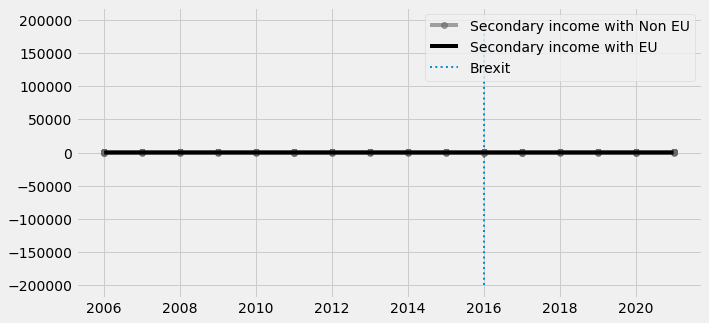

In [104]:
visulaize_origianl('EU','Secondary income', data_secondary)

## 5.2 Dataframe of Difference

### 5.2.1 Synthetic Control Method

In [105]:
synthetic_control_dataframe('EU','Secondary income', data_secondary)

Sum of weight: 1.0000000000000082


ValueError: shapes (16,78) and (77,) not aligned: 78 (dim 1) != 77 (dim 0)

5.2.1 Augmented Synthetic Control Method

In [ ]:
agumented_synthetic_control_dataframe('EU','CA', data_c)

In [ ]:
agumented_synthetic_control_dataframe('EU','Export of goods', data_g)

In [ ]:
agumented_synthetic_control_dataframe('EU','Export of service', data_s)

In [ ]:
agumented_synthetic_control_dataframe('EU','Total exports of goods and services', data_g_s)

In [ ]:
agumented_synthetic_control_dataframe('EU','Primary income', data_primary)

In [ ]:
agumented_synthetic_control_dataframe('EU','Secondary income', data_secondary)

## 5.3 Viusalization

5.3.1 Synthetic Control Method

In [ ]:
synthetic_plot('EU','CA', data_c)

In [ ]:
synthetic_plot('EU','Export of goods', data_g)

In [ ]:
synthetic_plot('EU','Export of service', data_s)

In [ ]:
synthetic_plot('EU','Total exports of goods and services', data_g_s)

In [ ]:
synthetic_plot('EU','Primary income', data_primary)

In [ ]:
synthetic_plot_magnified('EU','Secondary income', data_secondary)

### 5.3.2 Augmented Synthetic Control Method

In [ ]:
agumented_synthetic_control_visualize('EU','CA', data_c)

In [ ]:
agumented_synthetic_control_visualize('EU','Export of goods', data_g)

In [ ]:
agumented_synthetic_control_visualize('EU','Export of service', data_s)

In [ ]:
agumented_synthetic_control_visualize('EU','Total exports of goods and services', data_g_s)

In [ ]:
agumented_synthetic_control_visualize('EU','Primary income', data_primary)

In [ ]:
agumented_synthetic_control_visualize_magnified('EU','Secondary income', data_secondary)

# 6. Robust analysis

## 6.1 RSMPE table

In [ ]:
rmspe_table('CA', data_c)

In [ ]:
rmspe_table('Export of goods', data_g)

In [ ]:
rmspe_table('Export of service', data_s)

In [ ]:
rmspe_table('Total exports of goods and services', data_g_s)

In [ ]:
rmspe_table('Primary income', data_primary)

In [ ]:
rmspe_table('Secondary income', data_secondary)

## 6.1 in place placebo test

### 6.1.1 in-place placebo visulization

In [ ]:
placebo_visualize('EU','CA', data_c)

In [ ]:
placebo_visualize('EU','Export of goods', data_g)

In [ ]:
placebo_visualize('EU','Export of service', data_s)

In [ ]:
placebo_visualize('EU','Total exports of goods and services', data_g_s)

In [ ]:
placebo_visualize('EU','Primary income', data_primary)

In [ ]:
placebo_visualize('EU','Secondary income', data_secondary)

### 6.1.1 p-value of in-place placebo 

In [ ]:
p_value_analysis('EU','CA', data_c)

In [ ]:
p_value_analysis('EU','Export of goods', data_g)

In [ ]:
p_value_analysis('EU','Export of service', data_s)

In [ ]:
p_value_analysis('EU','Total exports of goods and services', data_g_s)

In [ ]:
p_value_analysis('EU','Primary income', data_primary)

In [ ]:
p_value_analysis('EU','Secondary income', data_secondary)

In [ ]:
## 6.2 limitation of donor pool

In [ ]:
agumented_synthetic_control_visualize_limit_donor_pool('EU','CA', data_c)

In [ ]:
agumented_synthetic_control_visualize_limit_donor_pool('EU','Export of goods', data_g)

In [ ]:
agumented_synthetic_control_visualize_limit_donor_pool('EU','Export of service', data_s)

In [ ]:
agumented_synthetic_control_visualize_limit_donor_pool('EU','Total exports of goods and services', data_g_s)

In [ ]:
agumented_synthetic_control_visualize_limit_donor_pool('EU','Primary income', data_primary)

In [ ]:
agumented_synthetic_control_visualize_limit_donor_pool_magnified('EU','Secondary income', data_secondary)

In [ ]:
import datetime
datetime.datetime.now().minute

In [ ]:
datetime.datetime.now().minute